In [201]:
"""An example notebook for a data_analysis notebook you may write.

Please use the recommended TNR font unless your venue requires otherwise.
"""

# Write down all of your code for data analysis in this file.
# Plot the data and save the figures/tables in the folders "plots" and "tables"

import seaborn as sns
# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
# Use TNR for all figures
# to match paper templates
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]


# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]
# I assume we don't need more than three so far...
CB_hatch_cycle = [
    "",
    "o",
    "xx",
    "***",
    "++++"
]

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from typing import List, Tuple
from dataclasses import dataclass

# 1. Results Analysis

In [52]:
NONFEDERATED_RESULTS_ROOT = Path.cwd().parent / "flashback-final-results" / "2024-03-24" / "05-15-35" / "+task"
MAIN_RESULTS_ROOT = Path.cwd().parent / "flashback-final-results" / "2024-03-24" / "05-15-21" / "+task"
POSTPROCESSED_PARTITION_ROOT = Path.cwd().parent / "data" / "flashback" / "partition"

SEEDS = (42, 361, 1337)

PLOTS_DESTINATION_DIR = Path.cwd() / "plots"

In [4]:
@dataclass
class Metrics:
    recall_at_1: List[Tuple[int, float]]
    recall_at_5: List[Tuple[int, float]]
    recall_at_10: List[Tuple[int, float]]
    mean_reciprocal_rank: List[Tuple[int, float]]

@dataclass
class History:
    losses_distributed: List[Tuple[int, float]]  # distributed test losses; list of (round, weighted averaged test loss at end of round >= 1)
    losses_centralised: List[Tuple[int, float]]  # centralised test losses; list of (round, test loss at end of round >= 0)
    metrics_distributed_fit: List[Tuple[int, float]]  # distributed train losses; list of (round, weighted averaged train loss at end of round >= 1)
    metrics_distributed: Metrics  # distributed test metrics; each subfield is a list of (round, weighted averaged test metric at end of round >= 1)
    metrics_centralised: Metrics  # centralised test metrics; each subfield is a list of (round, test metric at end of round >= 0)

def read_from_jsonpath(jsonpath: Path) -> History:
    with jsonpath.open("r") as f:
        dc = json.load(f)
    return History(
        losses_distributed=dc["losses_distributed"],
        losses_centralised=dc["losses_centralized"],
        metrics_distributed_fit=dc["metrics_distributed_fit"]["train_loss"],
        metrics_distributed=Metrics(
            recall_at_1=dc["metrics_distributed"]["recall@1"],
            recall_at_5=dc["metrics_distributed"]["recall@5"],
            recall_at_10=dc["metrics_distributed"]["recall@10"],
            mean_reciprocal_rank=dc["metrics_distributed"]["MAP"],
        ),
        metrics_centralised=Metrics(
            recall_at_1=dc["metrics_distributed"]["recall@1"],
            recall_at_5=dc["metrics_distributed"]["recall@5"],
            recall_at_10=dc["metrics_distributed"]["recall@10"],
            mean_reciprocal_rank=dc["metrics_distributed"]["MAP"],
        ),
    )

## 1.0. Hypothesis 0
Centralised performance

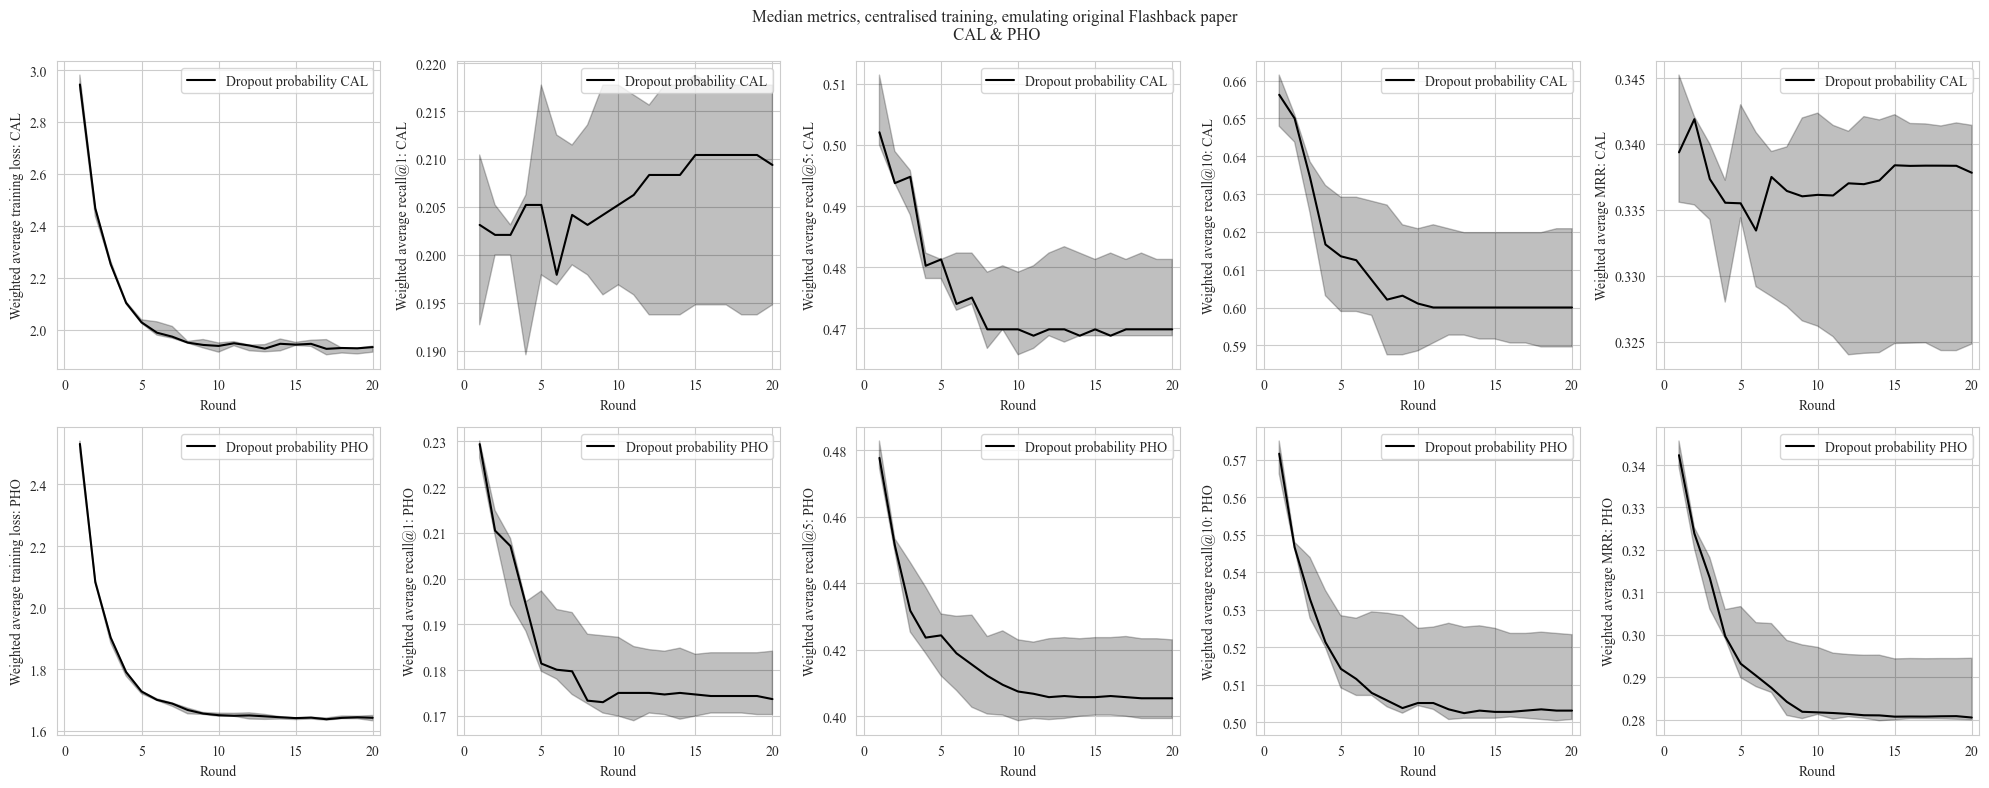

In [226]:
# Baseline comparable with main paper

# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "CAL": [],
        "PHO": [],
    },
    "recall@1": {
        "CAL": [],
        "PHO": [],
    },
    "recall@5": {
        "CAL": [],
        "PHO": [],
    },
    "recall@10": {
        "CAL": [],
        "PHO": [],
    },
    "MRR": {
        "CAL": [],
        "PHO": [],
    },
}

for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=centralised-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["CAL"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["CAL"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["CAL"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["CAL"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["CAL"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=centralised-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["PHO"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["PHO"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["PHO"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["PHO"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["PHO"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

cities = ("CAL", "PHO")

fig, axes = plt.subplots(2, len(metric_groups), figsize=(4 * len(metric_groups), 4 * 2), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for i, city in enumerate(cities):
    for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
        axes[i, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[city], axis=0),
            label=f"Dropout probability {city}",
            color="black",
            linestyle="solid"
        )
        axes[i, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[city], axis=0),
            np.max(metric_group[city], axis=0),
            color="black",
            hatch="",
            alpha=0.25
        )
        axes[i, j].legend()
        axes[i, j].set_xlabel("Round")
        axes[i, j].set_ylabel(f"Weighted average {metric_label}: {city}") #  (among per-round active clients)
        axes[i, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics, centralised training, emulating original Flashback paper\n CAL & PHO")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

## 1.1. Hypothesis 1

We measure performance using Recall@1, Recall@5, Recall@10 and MRR. Recall in a ranking system is defined as:
    $$\mathit{Recall} = \frac{\#(\mathit{Relevant}\wedge\mathit{Recommended}\text{ in top $k$})}{\#\mathit{Relevant}}$$
Here, there is only one relevant POI (the "correct answer"). Thus this reduces to
$$\mathit{Recall} = \mathbb{1}_{\text{Correct answer is }\mathit{Recommended}\text{ in top $k$}}$$
[Source](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)


Sequence length is 20. 101 is aligned to length-100 $\mathbf{X}$ and length-100 $\mathbf{Y}$. Split into 80-20. Take as many non-overalpping 20s from each, dropping any left over.

For each length-20 sequence $\mathbf{X}?$ and correct answers $\mathbf{Y}$. Make 20 predictions. Consider $X[:t+1]$ predict $Y[t]$ for $t\in\{0,\dots,19\}$.

In [220]:
def get_nonfederated_cal_jsonpaths(seed: int) -> List[Path]:
    return [
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal0-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal1-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal2-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal3-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal4-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal5-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal6-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal7-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal8-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal9-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal10-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal11-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal12-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal13-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal14-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal15-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal16-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal17-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal18-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal19-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal20-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal21-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal22-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal23-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal24-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal25-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-cal26-s{seed}" / "results" / "state" / "histories" / "history.json",
    ]

def get_nonfederated_pho_jsonpaths(seed: int) -> List[Path]:
    return [
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho0-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho1-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho2-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho3-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho4-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho5-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho6-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho7-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho8-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho9-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho10-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho11-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho12-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho13-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho14-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho15-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho16-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho17-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho18-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho19-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho20-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho21-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho22-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho23-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho24-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho25-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho26-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho27-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho28-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho29-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho30-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho31-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho32-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho33-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho34-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho35-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho36-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho37-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho38-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho39-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho40-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho41-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho42-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho43-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho44-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho45-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho46-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho47-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho48-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho49-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho50-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho51-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho52-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho53-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho54-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho55-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho56-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho57-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho58-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho59-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho60-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho61-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho62-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho63-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho64-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho65-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho66-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho67-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho68-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho69-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho70-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho71-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho72-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho73-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho74-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho75-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho76-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho77-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho78-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho79-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho80-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho81-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho82-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho83-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho84-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho85-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho86-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho87-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho88-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho89-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho90-s{seed}" / "results" / "state" / "histories" / "history.json",
        NONFEDERATED_RESULTS_ROOT / f"flashback-nonfederated=nonfederated-pho91-s{seed}" / "results" / "state" / "histories" / "history.json",
    ]

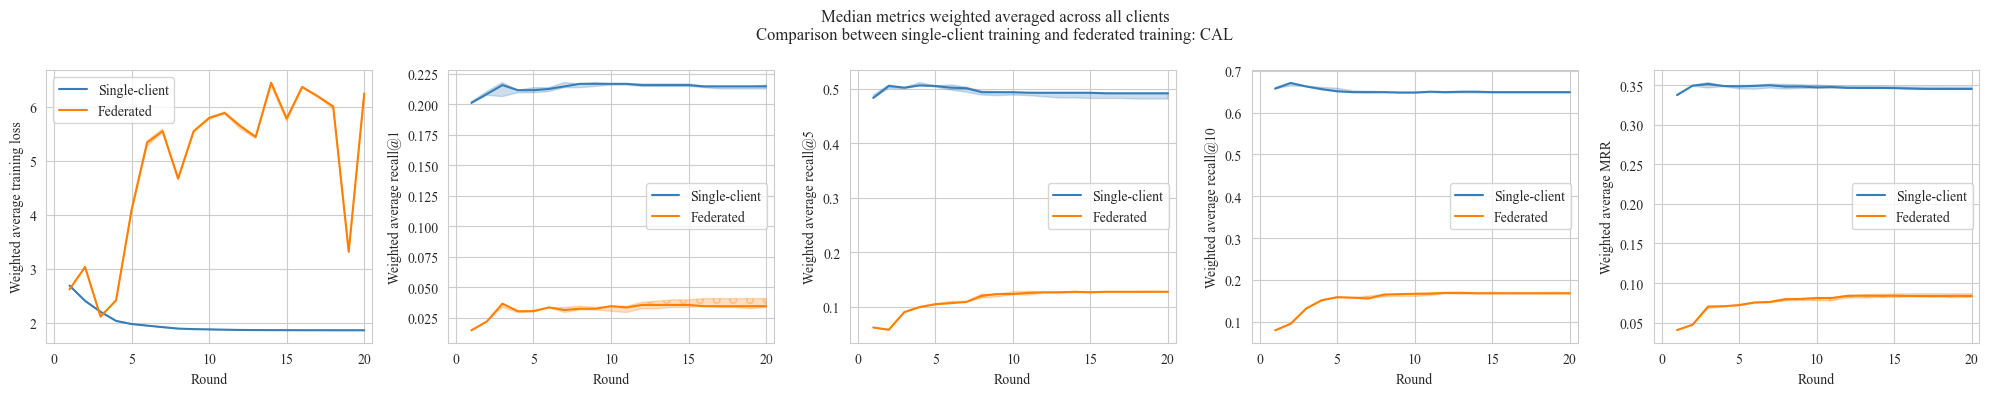

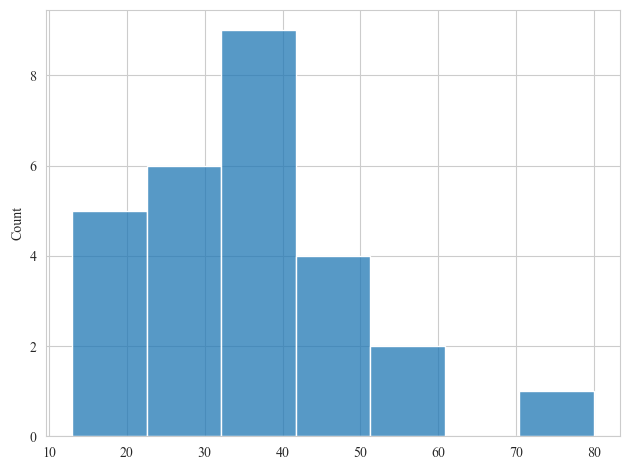

In [230]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@1": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@5": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@10": {
        "Single-client": [],
        "Federated": [],
    },
    "MRR": {
        "Single-client": [],
        "Federated": [],
    },
}

for seed in SEEDS:
    training_loss_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra1_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra5_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra10_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    mrr_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    total_numtestseq = 0

    client_test_dataset_unique_locations = []
    for client_id, client_jsonpath in enumerate(get_nonfederated_cal_jsonpaths(seed)):
        history = read_from_jsonpath(client_jsonpath)

        dataset_path = POSTPROCESSED_PARTITION_ROOT / "all_clients_nonfederated" / f"CAL-{client_id}" / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        # with dataset_path.open("r") as f:
        #     checkin_count = sum([1 for _ in f])
        checkin_count = len(df)
        checkin_count_after_offbyone_alignment = checkin_count - 1
        number_of_train_sequences = int(checkin_count_after_offbyone_alignment * 0.8) // 20
        number_of_test_sequences = (checkin_count_after_offbyone_alignment - int(checkin_count_after_offbyone_alignment * 0.8)) // 20
        assert number_of_train_sequences > 0  # sanity check
        assert number_of_test_sequences > 0  # sanity check
        client_test_dataset_unique_locations.append(len(df.loc[number_of_train_sequences:, 4].unique()))

        # Append a length-20 np.array representing each metric at the end of each round, for a particular user.
        # We take weighted average over all users after the for-loop.
        training_loss_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed_fit]))
        ra1_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
        ra5_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
        ra10_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
        mrr_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))
        total_numtestseq += number_of_test_sequences

    training_loss_perround = np.sum(training_loss_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra1_perround = np.sum(ra1_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra5_perround = np.sum(ra5_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra5 at end of each round
    ra10_perround = np.sum(ra10_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra10 at end of each round
    mrr_perround = np.sum(mrr_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average mrr at end of each round

    metric_groups["training loss"]["Single-client"].append(training_loss_perround)
    metric_groups["recall@1"]["Single-client"].append(ra1_perround)
    metric_groups["recall@5"]["Single-client"].append(ra5_perround)
    metric_groups["recall@10"]["Single-client"].append(ra10_perround)
    metric_groups["MRR"]["Single-client"].append(mrr_perround)


for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")

    metric_groups["training loss"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))


setups = ("Single-client", "Federated")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, setup in enumerate(setups):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[setup], axis=0),
            label=setup,
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[setup], axis=0),
            np.max(metric_group[setup], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between single-client training and federated training: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

# Debugging...

fig, ax = plt.subplots()
sns.histplot(client_test_dataset_unique_locations, ax=ax)
plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

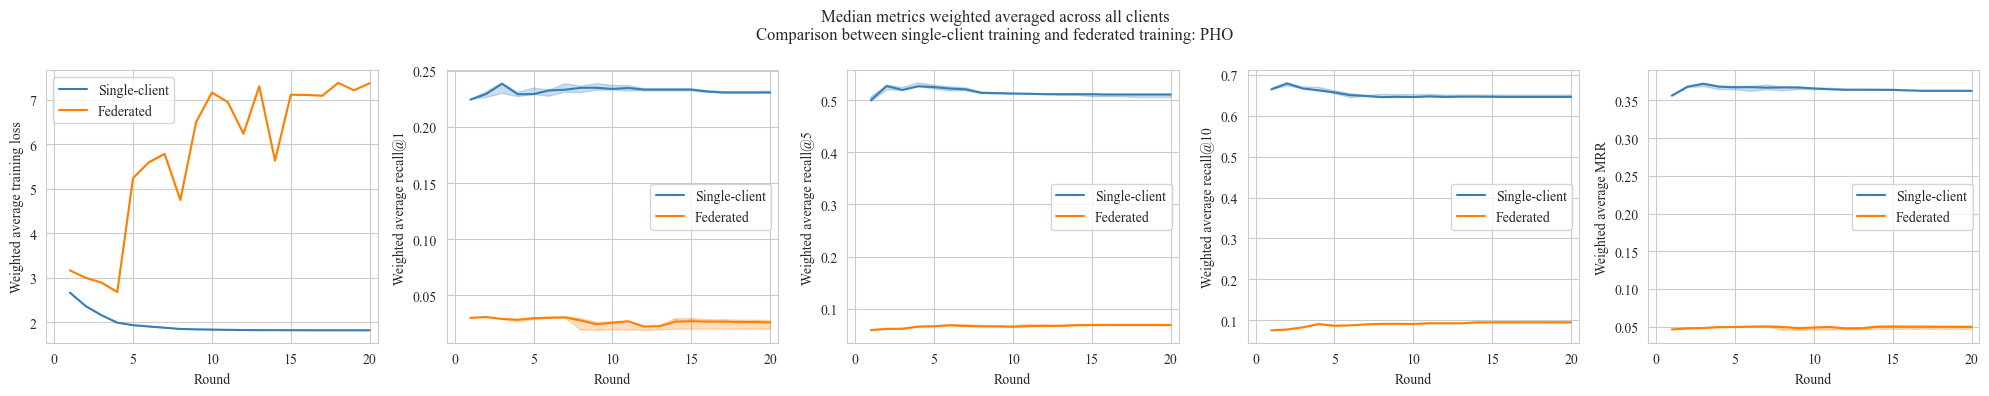

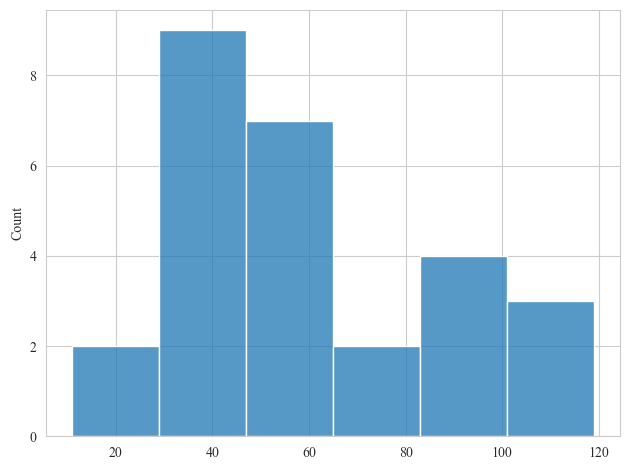

In [231]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@1": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@5": {
        "Single-client": [],
        "Federated": [],
    },
    "recall@10": {
        "Single-client": [],
        "Federated": [],
    },
    "MRR": {
        "Single-client": [],
        "Federated": [],
    },
}

for seed in SEEDS:
    training_loss_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra1_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra5_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    ra10_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    mrr_perround = []  # per-round metrics, weighted-averaged across all clients; will become np.arrays later
    total_numtestseq = 0

    client_test_dataset_unique_locations = []
    for client_id, client_jsonpath in enumerate(get_nonfederated_cal_jsonpaths(seed)):
        history = read_from_jsonpath(client_jsonpath)

        dataset_path = POSTPROCESSED_PARTITION_ROOT / "all_clients_nonfederated" / f"PHO-{client_id}" / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        # with dataset_path.open("r") as f:
        #     checkin_count = sum([1 for _ in f])
        checkin_count = len(df)
        checkin_count_after_offbyone_alignment = checkin_count - 1
        number_of_train_sequences = int(checkin_count_after_offbyone_alignment * 0.8) // 20
        number_of_test_sequences = (checkin_count_after_offbyone_alignment - int(checkin_count_after_offbyone_alignment * 0.8)) // 20
        assert number_of_train_sequences > 0  # sanity check
        assert number_of_test_sequences > 0  # sanity check
        client_test_dataset_unique_locations.append(len(df.loc[number_of_train_sequences:, 4].unique()))

        # Append a length-20 np.array representing each metric at the end of each round, for a particular user.
        # We take weighted average over all users after the for-loop.
        training_loss_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed_fit]))
        ra1_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
        ra5_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
        ra10_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
        mrr_perround.append(number_of_test_sequences * np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))
        total_numtestseq += number_of_test_sequences

    training_loss_perround = np.sum(training_loss_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra1_perround = np.sum(ra1_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra1 at end of each round
    ra5_perround = np.sum(ra5_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra5 at end of each round
    ra10_perround = np.sum(ra10_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average ra10 at end of each round
    mrr_perround = np.sum(mrr_perround, axis=0) / total_numtestseq  # length-20 np.array; weighted average mrr at end of each round

    metric_groups["training loss"]["Single-client"].append(training_loss_perround)
    metric_groups["recall@1"]["Single-client"].append(ra1_perround)
    metric_groups["recall@5"]["Single-client"].append(ra5_perround)
    metric_groups["recall@10"]["Single-client"].append(ra10_perround)
    metric_groups["MRR"]["Single-client"].append(mrr_perround)


for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")

    metric_groups["training loss"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Federated"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))


setups = ("Single-client", "Federated")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, setup in enumerate(setups):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[setup], axis=0),
            label=setup,
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[setup], axis=0),
            np.max(metric_group[setup], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between single-client training and federated training: PHO")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

# Debugging...

fig, ax = plt.subplots()
sns.histplot(client_test_dataset_unique_locations, ax=ax)
plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

Length of dataset (used as weights in FedAvg) is just <# full length-20 sequences>

## Hypothesis 2

### Quantity skew: Distribution of Client Dataset Sizes

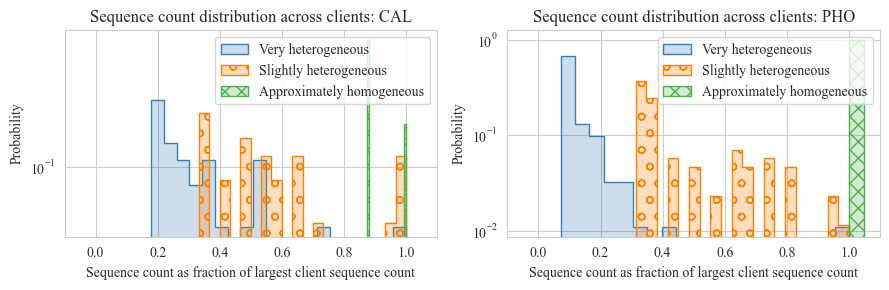

In [227]:
heterogeneities = {
    "Very heterogeneous": "all_clients",
    "Slightly heterogeneous": "smaller_quantity_skew",
    "Approximately homogeneous": "homogeneous_approximation",
}

fig, axes = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
X_AXIS_ALLOWANCE = 0.1

for j, city in enumerate(("CAL", "PHO")):
    for k, (heterogeneity_label, heterogeneity_getter) in enumerate(heterogeneities.items()):
        dataset_path = POSTPROCESSED_PARTITION_ROOT / heterogeneity_getter / city / "centralised" / "client_0.txt"
        df = pd.read_csv(dataset_path, sep="\t", header=None)
        num_checkins_per_user = df.loc[:, 0].value_counts()
        num_checkins_per_user -= 1  # after adjusting for off-by-one alignment of seq2seq input/output
        num_trainseq_per_user = np.floor(num_checkins_per_user * 0.8) // 20
        num_testseq_per_user = (num_checkins_per_user - np.floor(num_checkins_per_user * 0.8)) // 20
        num_seq_per_user = num_trainseq_per_user + num_testseq_per_user
        sns.histplot(
            alpha=0.25,
            legend=True,
            data=num_seq_per_user / num_seq_per_user.max(),
            fill=True,
            bins=20,
            # kde=True,
            element="step",
            stat="probability",
            common_norm=False,  # there is only 1 histogram here, so this is inconsequential
            common_bins=True,
            cbar=True,  # this is a univariate plot (1 dependent variable: # samples), so this is inconsequential
            color=CB_color_cycle[k],
            label=heterogeneity_label,
            ax=axes[0, j]
        )

    # Histplot hatching courtesy of https://stackoverflow.com/a/35477440
    for k, plot in enumerate(axes[0, j].collections):
        # Set a different hatch for each bar
        plot.set_hatch(CB_hatch_cycle[k])

    axes[0, j].legend()
    axes[0, j].set_title(f"Sequence count distribution across clients: {city}")
    axes[0, j].set_xlabel("Sequence count as fraction of largest client sequence count")
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 1 + X_AXIS_ALLOWANCE))
    axes[0, j].set_yscale("log")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

### Results

In [ ]:
# Hypothesis 2
[
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
]

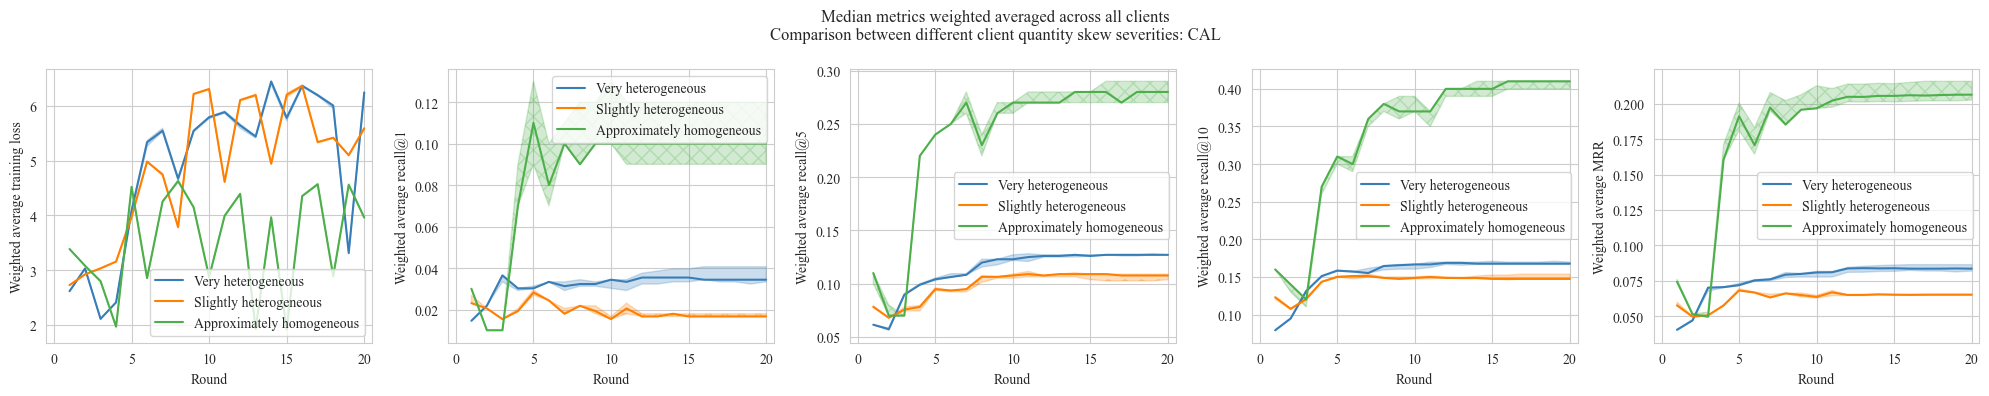

In [195]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@1": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@5": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@10": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "MRR": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
}

for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

heterogeneities = ("Very heterogeneous", "Slightly heterogeneous", "Approximately homogeneous")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, dropout_probability in enumerate(heterogeneities):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[dropout_probability], axis=0),
            label=dropout_probability,
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[dropout_probability], axis=0),
            np.max(metric_group[dropout_probability], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different client quantity skew severities: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

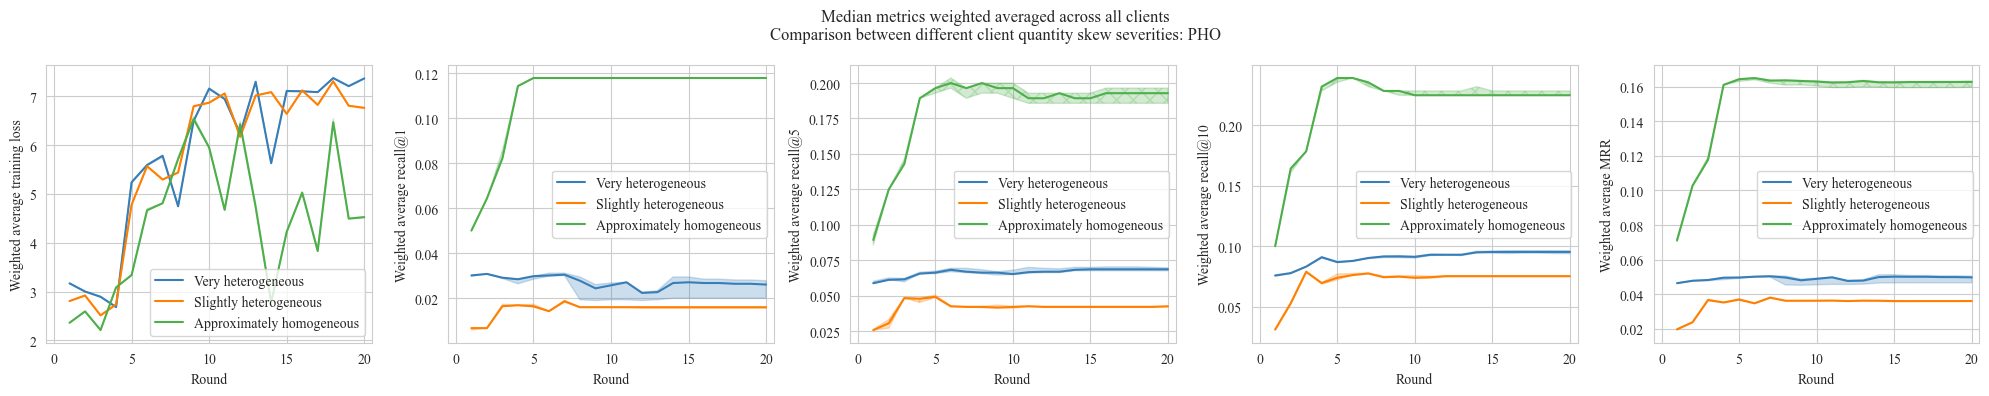

In [196]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@1": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@5": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "recall@10": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
    "MRR": {
        "Very heterogeneous": [],
        "Slightly heterogeneous": [],
        "Approximately homogeneous": [],
    },
}

for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Very heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-sqs-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Slightly heterogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ha-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["Approximately homogeneous"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

heterogeneities = ("Very heterogeneous", "Slightly heterogeneous", "Approximately homogeneous")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, dropout_probability in enumerate(heterogeneities):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[dropout_probability], axis=0),
            label=dropout_probability,
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[dropout_probability], axis=0),
            np.max(metric_group[dropout_probability], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different client quantity skew severities: PHO")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

## Hypothesis 3

In [ ]:
# Hypothesis 3
[
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json",
    MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json",
]

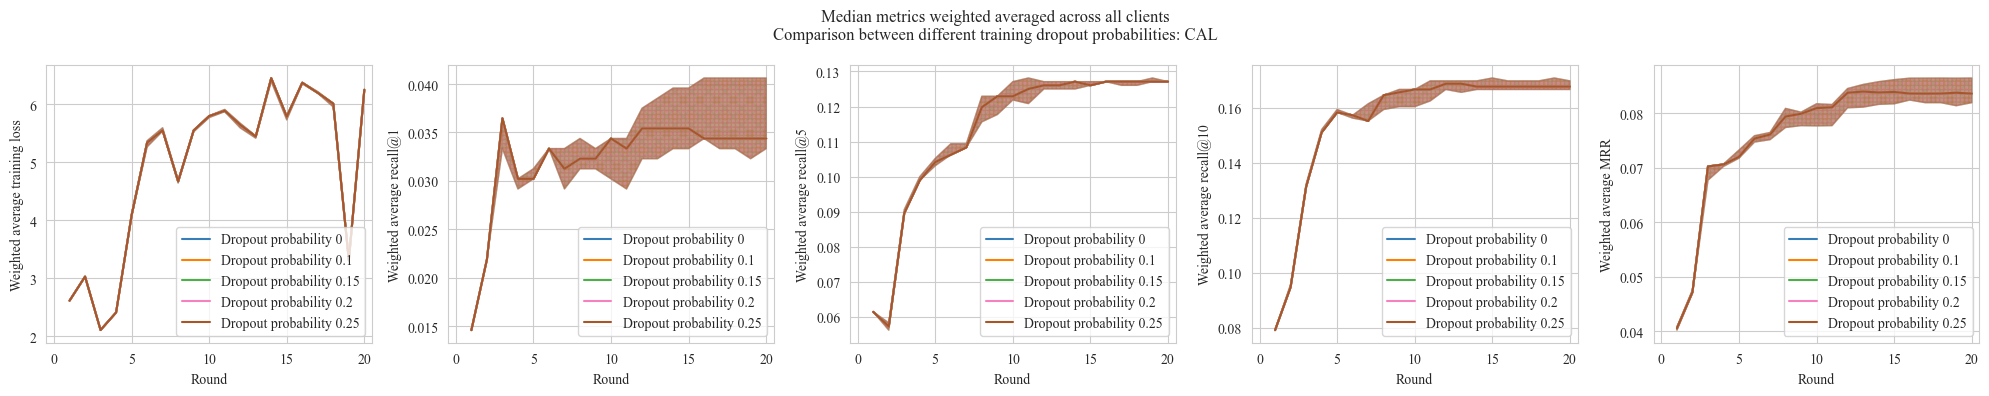

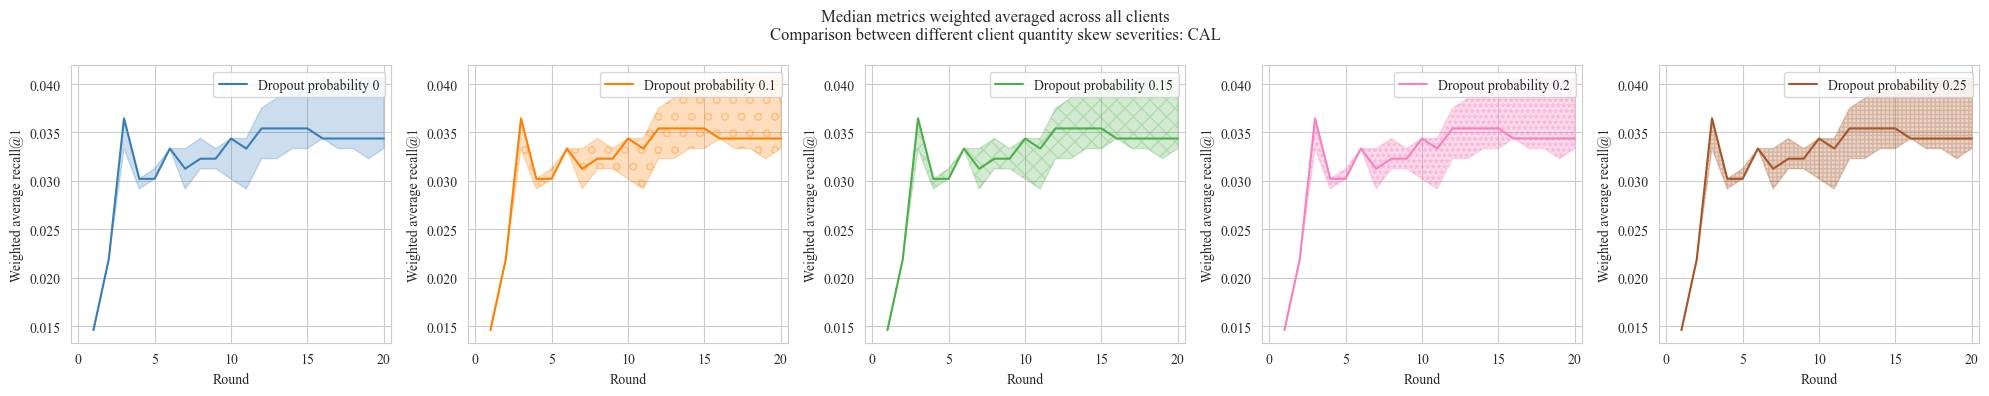

In [216]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@1": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@5": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@10": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "MRR": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
}

for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-cal-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

dropout_probabilities = ("0", "0.1", "0.15", "0.2", "0.25")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, dropout_probability in enumerate(dropout_probabilities):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[dropout_probability], axis=0),
            label=f"Dropout probability {dropout_probability}",
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[dropout_probability], axis=0),
            np.max(metric_group[dropout_probability], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different training dropout probabilities: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")


# The following is for deeper inspection into overlapping regions:

fig, axes = plt.subplots(1, len(dropout_probabilities), figsize=(4 * len(dropout_probabilities), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20
CHOSEN_METRIC = "recall@1"

for j, dropout_probability in enumerate(dropout_probabilities):
    axes[0, j].plot(
        np.arange(1, NUM_ROUNDS + 1),
        np.median(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        label=f"Dropout probability {dropout_probability}",
        color=CB_color_cycle[j],
        linestyle="solid"
    )
    axes[0, j].fill_between(
        np.arange(1, NUM_ROUNDS + 1),
        np.min(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        np.max(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        color=CB_color_cycle[j],
        hatch=CB_hatch_cycle[j],
        alpha=0.25
    )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {CHOSEN_METRIC}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different client quantity skew severities: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")

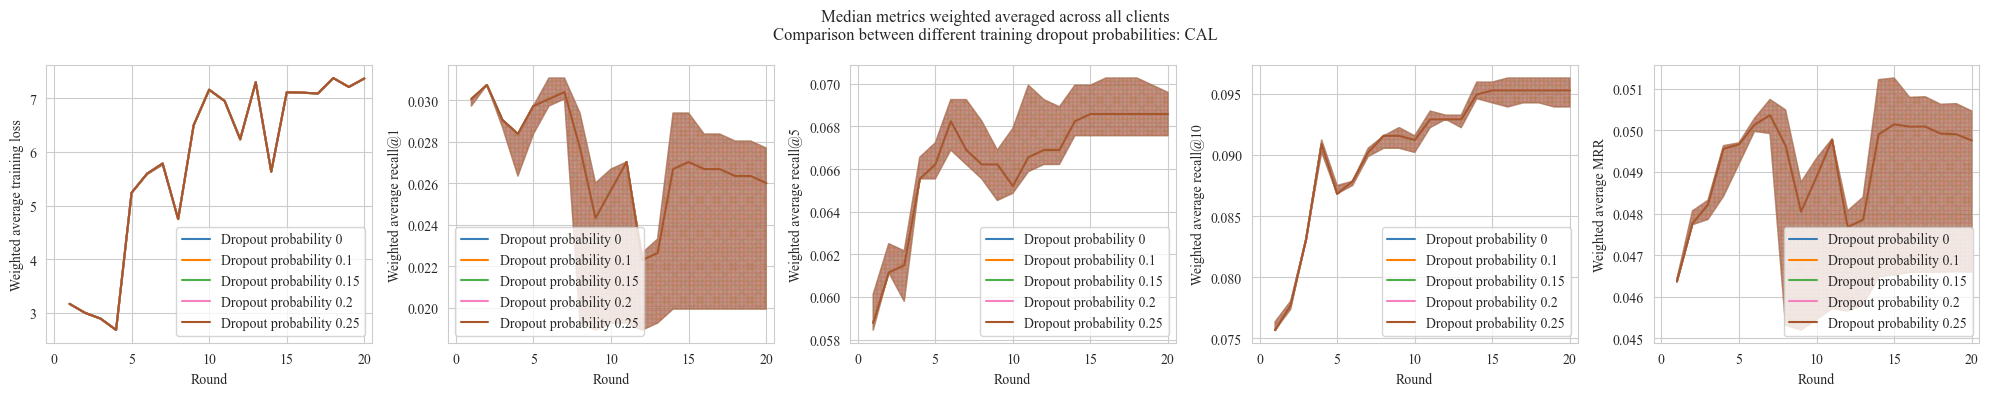

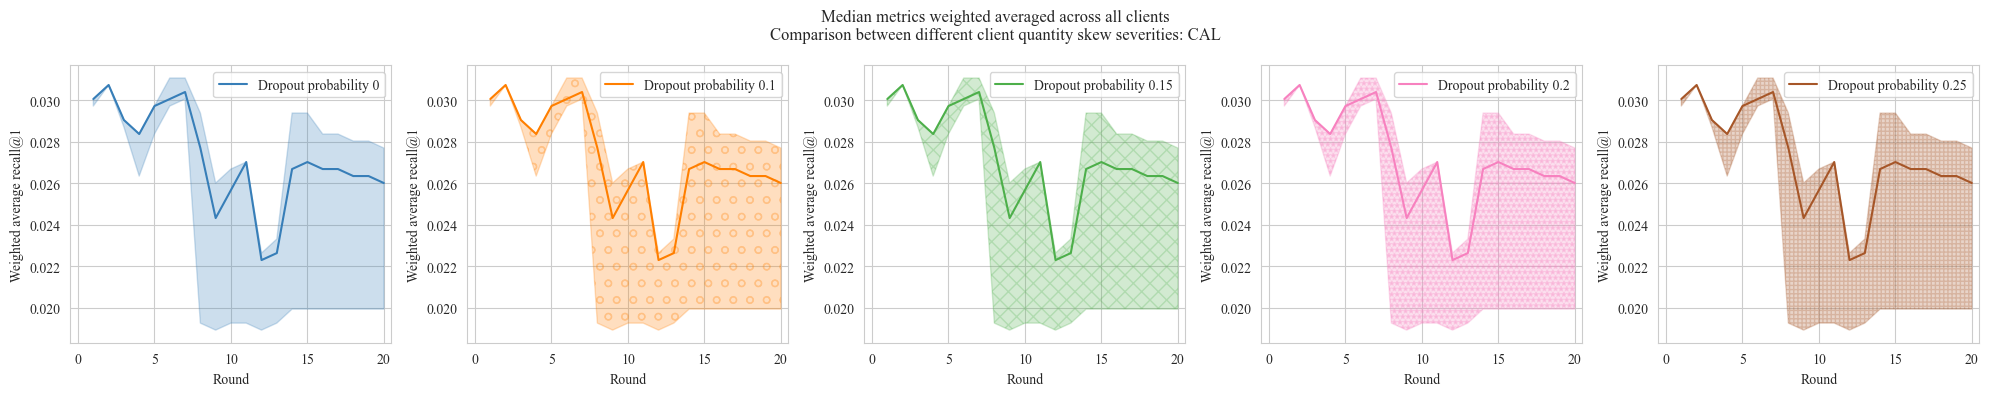

In [219]:
# Lists here are all of the form
# [
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #1],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #2],
#     [length-NUM_ROUNDS list of weighted averaged metric for seed #3],
# ]
metric_groups = {
    "training loss": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@1": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@5": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "recall@10": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
    "MRR": {
        "0": [],
        "0.1": [],
        "0.15": [],
        "0.2": [],
        "0.25": [],
    },
}

for seed in SEEDS:
    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p0-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p1-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.1"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p15-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.15"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p2-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.2"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

    history = read_from_jsonpath(MAIN_RESULTS_ROOT / f"flashback=federated-pho-ac-d0p25-s{seed}" / "results" / "state" / "histories" / "history.json")
    metric_groups["training loss"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed_fit]))
    metric_groups["recall@1"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_1]))
    metric_groups["recall@5"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_5]))
    metric_groups["recall@10"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.recall_at_10]))
    metric_groups["MRR"]["0.25"].append(np.array([v for round_num, v in history.metrics_distributed.mean_reciprocal_rank]))

dropout_probabilities = ("0", "0.1", "0.15", "0.2", "0.25")

fig, axes = plt.subplots(1, len(metric_groups), figsize=(4 * len(metric_groups), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20

for j, (metric_label, metric_group) in enumerate(metric_groups.items()):
    for k, dropout_probability in enumerate(dropout_probabilities):
        axes[0, j].plot(
            np.arange(1, NUM_ROUNDS + 1),
            np.median(metric_group[dropout_probability], axis=0),
            label=f"Dropout probability {dropout_probability}",
            color=CB_color_cycle[k],
            linestyle="solid"
        )
        axes[0, j].fill_between(
            np.arange(1, NUM_ROUNDS + 1),
            np.min(metric_group[dropout_probability], axis=0),
            np.max(metric_group[dropout_probability], axis=0),
            color=CB_color_cycle[k],
            hatch=CB_hatch_cycle[k],
            alpha=0.25
        )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {metric_label}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different training dropout probabilities: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")


# The following is for deeper inspection into overlapping regions:

fig, axes = plt.subplots(1, len(dropout_probabilities), figsize=(4 * len(dropout_probabilities), 4), squeeze=False)
X_AXIS_ALLOWANCE = 0.5
NUM_ROUNDS = 20
CHOSEN_METRIC = "recall@1"

for j, dropout_probability in enumerate(dropout_probabilities):
    axes[0, j].plot(
        np.arange(1, NUM_ROUNDS + 1),
        np.median(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        label=f"Dropout probability {dropout_probability}",
        color=CB_color_cycle[j],
        linestyle="solid"
    )
    axes[0, j].fill_between(
        np.arange(1, NUM_ROUNDS + 1),
        np.min(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        np.max(metric_groups[CHOSEN_METRIC][dropout_probability], axis=0),
        color=CB_color_cycle[j],
        hatch=CB_hatch_cycle[j],
        alpha=0.25
    )
    axes[0, j].legend()
    axes[0, j].set_xlabel("Round")
    axes[0, j].set_ylabel(f"Weighted average {CHOSEN_METRIC}") #  (among per-round active clients)
    axes[0, j].set_xlim((0 - X_AXIS_ALLOWANCE, 20 + X_AXIS_ALLOWANCE))

fig.suptitle("Median metrics weighted averaged across all clients\nComparison between different client quantity skew severities: CAL")

plt.tight_layout()
plt.savefig(PLOTS_DESTINATION_DIR / "t.pdf", bbox_inches="tight")